<a href="https://colab.research.google.com/github/vshalisko/GEE/blob/main/AUEM/Taller_20241217/ESE_preprocesamiento_zona_estudio_con_reduccion_nubes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Ensayo 2024.12.17
## Ensenada
### Visuzlización de zona de estudio en Colab - GEE
### Vesión con el proceso de generar mosaico para combinar imagenes de varias zonas y/o para eliminar nubes


In [20]:
## Definir variables

## Prefilo de zona
prefijo = "ESE"

## Ruta en Google Drive (se requiere crear una carpeta en raíz de Google Drive)
ruta = "Colab Data"

## Punto de centro de zona en coordenadas geográficas
punto_interes_text = [-116.6064, 31.8680]

## Proyeccion UTM aplicable
projection_text = "EPSG:32611"

## limites de rectangulo de zona de estudio en UTM
#limites_utm = [531951, 547066, 3513217, 3532728]    # versión agosto 2024
limites_utm = [523989, 548709, 3502560, 3532709]

## tamaño de pixel
pixel = 30

## número de pixeles máximo en segmento
max_tile = 50000

## fechas para imagenes de satelite
#inicio_2015 = "2015-02-01"
#final_2015 = "2015-06-30"

## datos para definición de rango de fechas imagenes de satelite
## rango de meses
m_inicio = 2
m_final = 6
## rango de años
y_inicio_2015 = 2015
y_final_2015 = 2015

## bandas de L8 utiles
bands_L8 = ['SR_B2','SR_B3','SR_B4','SR_B5','SR_B6','SR_B7']

## bandas de capa de referencia
bands_B = ['settlement']
#bands_B = ['WSF']

#### Praparar el entorno

In [21]:
## cargar bibliotecas GEE y GEEmap
import ee
import geemap
from google.colab import drive
import math
import numpy as np
import matplotlib.pyplot as plt
from osgeo import gdal, osr


# Iniciar autentificacion
ee.Authenticate()

# Inicializar proyecto GEE
ee.Initialize(project='ee-vshalisko')

## Inicializar Google Drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#### Preparar datos para GEE

In [22]:
punto_interes = ee.Geometry.Point(punto_interes_text)

projection = ee.Projection(projection_text)

bbox = ee.Geometry.Rectangle([limites_utm[0], limites_utm[2], limites_utm[1], limites_utm[3]], projection, True, False)

#### Definir funciones auxiliares para control de nubes y calidad de pixeles

In [23]:
## funcion para eliminar nubes y sombras
def maskClouds(image):
    qa = image.select('QA_PIXEL')
    cloud_shadow_bit_mask = (1 << 3)
    cloud_bit_mask = (1 << 4)
    cloud_mask = qa.bitwiseAnd(cloud_shadow_bit_mask).eq(0).And(qa.bitwiseAnd(cloud_bit_mask).eq(0))
    return image.updateMask(cloud_mask)

#### Seleccionar imagen Landsat 8 para el año 2015

In [24]:
## Ejemplo de coleccion con presencia de nubes
L8_collection_2015 = (ee.ImageCollection("LANDSAT/LC08/C02/T1_L2")
                      .filterBounds(punto_interes)
                      .filter(ee.Filter.calendarRange(m_inicio,m_final,"month"))
                      .filter(ee.Filter.calendarRange(y_inicio_2015, y_final_2015, "year"))
                      .filter(ee.Filter.lessThan("CLOUD_COVER", 4)))

print('Capas de datos filtrados 2015:', L8_collection_2015.size().getInfo())

# Cargar imagen de la colección (Landsat 8).
L8_image_2015 = L8_collection_2015.first()
image_meta_2015 = L8_image_2015.getInfo()
imagename_2015 = image_meta_2015.get('properties',{}).get('LANDSAT_PRODUCT_ID')
print('Imagen 2015 elegido:', imagename_2015)

## obtener lista de nombres de bandas
bands_original_names = L8_image_2015.bandNames();

## Extraer datos de proyeccion de la imagen L8
projection = L8_image_2015.projection().getInfo();

## Consultar datos de la proyección
print(projection.get('crs'))
print(projection.get('transform'))

## generar el mosaico de 2015
L8_image_2015_mosaic = L8_collection_2015.map(maskClouds).reduce(ee.Reducer.mean())

## renombrar bandas al esquema original
L8_image_2015_mosaic = L8_image_2015_mosaic.rename(bands_original_names)

## asignar proyeccion al mosaico
L8_image_2015_re = L8_image_2015_mosaic.reproject(projection.get('crs'), projection.get('transform'), None)

Capas de datos filtrados 2015: 2
Imagen 2015 elegido: LC08_L2SP_039038_20150606_20200909_02_T1
EPSG:32611
[30, 0, 479985, 0, -30, 3628215]


#### Cargar y preparar datos categoricos para 2015

In [50]:
# Cargar builtup 2015 (res 10 m) y reclasificar a 0 y 1
built_2015_hr = ee.Image('DLR/WSF/WSF2015/v1')
built_2015_hr = built_2015_hr.where(built_2015_hr.eq(255), 1)

# Cargar cuerpor de agua (res 30)
elev_dataset = ee.ImageCollection('COPERNICUS/DEM/GLO30').filterBounds(L8_image_2015.geometry())
print('Segmentos WBM filtrados:', elev_dataset.size().getInfo())
MDE_Copernicus_proj = elev_dataset.first().projection()
water_mosaico = elev_dataset.select('WBM').mosaic()
water_mosaico = water_mosaico.setDefaultProjection(MDE_Copernicus_proj)
water_binary = water_mosaico.gt(0)

## Datos categoricas deben quedar en misma proyección de Landsat 8, con mismo tamaño y resolución
## Reproyectar layers
built_2015_hr_reprojected = built_2015_hr.reproject(projection.get('crs'), projection.get('transform'))
water_binary_reprojected = water_binary.reproject(projection.get('crs'), projection.get('transform'))

## Combinar capas de builtup y agua en una capa categorica de tres clases (0 - no-urbano, 1 - agua, 2 - urbano)
built_2015_agua_hr_reprojected = built_2015_hr_reprojected.unmask(0)
built_2015_agua_hr_reprojected = (built_2015_agua_hr_reprojected.where(built_2015_agua_hr_reprojected.eq(1), 2))
built_2015_agua_hr_reprojected = (built_2015_agua_hr_reprojected.where(water_binary_reprojected.eq(1), 1))

## renombrar capa resultante
built_2015_hr_reprojected = built_2015_hr_reprojected.rename(bands_B)

## renombrar capa resultante
#built_2015_agua_hr_reprojected = built_2015_agua_hr_reprojected.rename(bands_B).setDefaultProjection(L8_image_2015.projection())
built_2015_agua_hr_reprojected = built_2015_agua_hr_reprojected.rename(bands_B)
print(built_2015_agua_hr_reprojected.getInfo())

Segmentos WBM filtrados: 8
{'type': 'Image', 'bands': [{'id': 'settlement', 'data_type': {'type': 'PixelType', 'precision': 'int', 'min': 0, 'max': 255}, 'crs': 'EPSG:32611', 'crs_transform': [30, 0, 479985, 0, -30, 3628215]}], 'version': 1728918335381151, 'id': 'DLR/WSF/WSF2015/v1', 'properties': {'system:footprint': {'type': 'LinearRing', 'coordinates': [[-180, -90], [180, -90], [180, 90], [-180, 90], [-180, -90]]}, 'system:asset_size': 6718369799}}


#### Visualizar datos en GEE

In [44]:
## Parametros de visualizacion del poligono
visPol = {
  'color': '0000FF',
  'width': 2,
  'opacity': 0.25
};

## Parametros de visualizacion para Landsat 8
vizParams_L8 = {
  'bands': ['SR_B5', 'SR_B4', 'SR_B3'],
   'min': 5000,
   'max': 15000
}

## Parametros de visualizacion para capa categorica
vizBuiltupAgua = {
   'min': 0,
   'max': 2,
  'palette': ['beige', 'blue', 'black']
}

## definir ventana de mapa
map = geemap.Map()

## Centrar
map.centerObject(punto_interes, 10)


## Agregar capas de datos al mapa
map.addLayer(L8_image_2015, vizParams_L8, "2015 solo Composición de falso color", False, 0.5)
map.addLayer(L8_image_2015_re, vizParams_L8, '2015 mosaic Composición de falso color', True, 0.5)
map.addLayer(built_2015_agua_hr_reprojected, vizBuiltupAgua, 'referencia categorica', True, 0.5)
map.addLayer(bbox, visPol, "Area de estudio", True, 1)
map.addLayer(punto_interes, {}, "Punto de centro", True, 1)


## Presentar el mapa
map

Map(center=[31.868000000000002, -116.6064], controls=(WidgetControl(options=['position', 'transparent_bg'], wi…

#### Definición de los segmentos para descarga y conversión de datos desde GEE a numpy

In [67]:
def segmentation(limits, pixel_size, max_tile_size, proj):
  alto_px = math.ceil((limits[3] - limits[2]) / pixel_size)
  ## alto en pixeles
  print('Alto del segmento (pixeles)', alto_px)
  ## ancho estandar de segmento en pixeles
  ancho_px = math.ceil(max_tile_size / alto_px)
  print('Ancho del segmento (pixeles)', ancho_px)
  ## ancho astandar de segmento en unidades de proyeccion
  incremento = ancho_px * pixel_size
  print('Ancho del segmento (unidades de proyeccion)', incremento)
  ## lista de los límites x de segmentos
  seq = list(np.arange(limits[0], limits[1], incremento))
  seq.append(limites_utm[1])
  print('Secuencia de marcas de longitud para los segmentos')
  print(seq)

  ## definición de las geometrias rectangulares de segmentos
  segments = []
  for i in range(len(seq)-1):
    #print(seq[i], seq[i+1])
    segment = ee.Geometry.Rectangle([int(seq[i]), limites_utm[2], int(seq[i+1]), limites_utm[3]], proj, True, False)
    #print(segment)
    segments.append(segment)

  return segments

## llamar funcion que genera geometrias de segmentos
segment_list = segmentation(limites_utm, pixel, max_tile, projection_text)

## Agregar capas de datos al mapa 1
map1 = geemap.Map()
map1.centerObject(punto_interes, 10)
map1.addLayer(bbox, {}, 'Area de estudio', False, 0.5)

for i in range(len(segment_list)):
  segment_name = "segment " + str(i)
  map1.addLayer(segment_list[i], {}, segment_name, True, 0.3)

## Presentar el mapa
map1

Alto del segmento (pixeles) 1005
Ancho total esperado (pixeles) 824
Ancho del segmento (pixeles) 50
Ancho del segmento (unidades de proyeccion) 1500
Secuencia de marcas de longitud para los segmentos
[523989, 525489, 526989, 528489, 529989, 531489, 532989, 534489, 535989, 537489, 538989, 540489, 541989, 543489, 544989, 546489, 547989, 548709]


Map(center=[31.868000000000002, -116.6064], controls=(WidgetControl(options=['position', 'transparent_bg'], wi…

#### Funciones para descarga y conversión de datos GEE

In [40]:
def tile_to_numpy(image, rectangle, bands):
  ## extraccion de bandas en un region rectangular
  image_tile = image.sampleRectangle(region=rectangle,defaultValue=0)
  first_band = image_tile.get(bands[0])
  band_array_np = np.array(first_band.getInfo())
  band_array_np = np.expand_dims(band_array_np, 2)
  for b in bands[1:]:
    b_arr = image_tile.get(b)
    b_arr_np = np.array(b_arr.getInfo())
    b_arr_np = np.expand_dims(b_arr_np, 2)
    #print(b_arr_np.shape)
    #print(band_array_np.shape)
    band_array_np = np.concatenate((band_array_np, b_arr_np), 2)
  return band_array_np

def merge_feature_array(image, segments, bands):
  ## combinaccion de segmentos
  array_feature = tile_to_numpy(image, segments[0], bands)
  print("New feature array", array_feature.shape)
  for segment in segments[1:]:
    feature_segment = tile_to_numpy(image, segment, bands)
    print("Feature segment", feature_segment.shape)
    array_feature = np.concatenate((array_feature, feature_segment), 1)
  print("Full new feature array", array_feature.shape)
  return array_feature

#### Descarga Landsat 8 para 2015

New feature array (1006, 51, 6)
Feature segment (1006, 51, 6)
Feature segment (1006, 51, 6)
Feature segment (1006, 51, 6)
Feature segment (1006, 51, 6)
Feature segment (1006, 51, 6)
Feature segment (1006, 51, 6)
Feature segment (1006, 51, 6)
Feature segment (1006, 51, 6)
Feature segment (1006, 51, 6)
Feature segment (1006, 51, 6)
Feature segment (1006, 51, 6)
Feature segment (1006, 51, 6)
Feature segment (1006, 51, 6)
Feature segment (1006, 51, 6)
Feature segment (1006, 51, 6)
Feature segment (1006, 25, 6)
Full new feature array (1006, 841, 6)


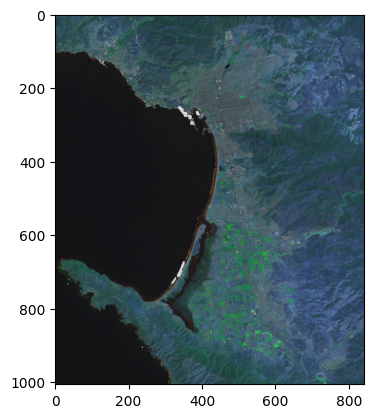

In [29]:
array_feature_2015 = merge_feature_array(L8_image_2015_re, segment_list, bands_L8)

# Reescalar datos a rango [0, 255] y representar como imagen RGB
rgb_img_new = (255*((array_feature_2015 - 5000)/30000)).astype('uint8')
plt.imshow(rgb_img_new[:,:,2:5])
plt.show()

Descarga datos categoricos 2015

New feature array (1006, 51, 1)
Feature segment (1006, 51, 1)
Feature segment (1006, 51, 1)
Feature segment (1006, 50, 1)
Feature segment (1006, 51, 1)
Feature segment (1006, 51, 1)
Feature segment (1006, 51, 1)
Feature segment (1006, 50, 1)
Feature segment (1006, 51, 1)
Feature segment (1006, 51, 1)
Feature segment (1006, 51, 1)
Feature segment (1006, 50, 1)
Feature segment (1006, 51, 1)
Feature segment (1006, 51, 1)
Feature segment (1006, 51, 1)
Feature segment (1006, 50, 1)
Feature segment (1006, 29, 1)
Full new feature array (1006, 841, 1)


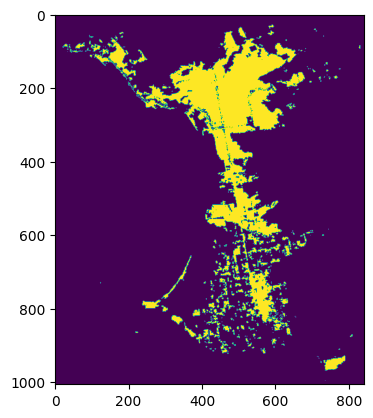

Valores únicos de clases [0 1]
Conteo de pixeles de valores únicos [743180 102866]
New feature array (1006, 51, 1)
Feature segment (1006, 51, 1)
Feature segment (1006, 51, 1)
Feature segment (1006, 50, 1)
Feature segment (1006, 51, 1)
Feature segment (1006, 51, 1)
Feature segment (1006, 51, 1)
Feature segment (1006, 50, 1)
Feature segment (1006, 51, 1)
Feature segment (1006, 51, 1)
Feature segment (1006, 51, 1)
Feature segment (1006, 50, 1)
Feature segment (1006, 51, 1)
Feature segment (1006, 51, 1)
Feature segment (1006, 51, 1)
Feature segment (1006, 50, 1)
Feature segment (1006, 29, 1)
Full new feature array (1006, 841, 1)


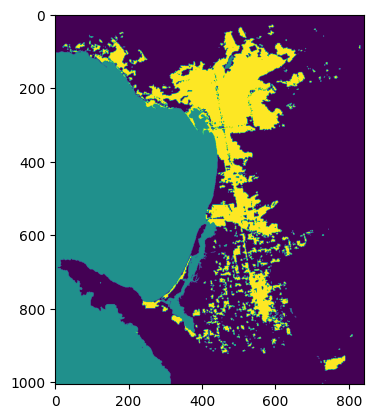

Valores únicos de clases [0 1 2]
Conteo de pixeles de valores únicos [458443 285662 101941]


In [63]:
## Variante de capa binaria
array_target_binary_2015 = merge_feature_array(built_2015_hr_reprojected, segment_list, bands_B)

## Reescalar datos a rango [0, 255] y representar como imagen RGB
rgb_img_new = (array_target_binary_2015).astype('uint8')
plt.imshow(rgb_img_new[:,:,0])
plt.show()

unique_values_bin, occurrence_count_bin = np.unique(array_target_binary_2015, return_counts=True)
print('Valores únicos de clases', unique_values_bin)
print('Conteo de pixeles de valores únicos', occurrence_count_bin)

## Variante de capa de tres clases
array_target_2015 = merge_feature_array(built_2015_agua_hr_reprojected, segment_list, bands_B)

## Reescalar datos a rango [0, 255] y representar como imagen RGB
rgb_img_new = (array_target_2015).astype('uint8')
plt.imshow(rgb_img_new[:,:,0])
plt.show()

unique_values, occurrence_count = np.unique(array_target_2015, return_counts=True)
print('Valores únicos de clases', unique_values)
print('Conteo de pixeles de valores únicos', occurrence_count)

#### Guardar datos en numpy arrays en Google Drive

In [64]:
ruta_L8_2015 = "/content/drive/MyDrive/" + ruta + "/" + prefijo + "_2015_feature_L8_6b.npy"
print(ruta_L8_2015)

ruta_target_2015 = "/content/drive/MyDrive/" + ruta + "/" + prefijo + "_2015_target.npy"
print(ruta_target_2015)

ruta_target_binary_2015 = "/content/drive/MyDrive/" + ruta + "/" + prefijo + "_2015_target_binary.npy"
print(ruta_target_binary_2015)

np.save(ruta_L8_2015, array_feature_2015)
np.save(ruta_target_2015, array_target_2015)
np.save(ruta_target_binary_2015, array_target_binary_2015)

/content/drive/MyDrive/Colab Data/ESE_2015_feature_L8_6b.npy
/content/drive/MyDrive/Colab Data/ESE_2015_target.npy
/content/drive/MyDrive/Colab Data/ESE_2015_target_binary.npy


#### Preparar guardado de datos en GeoTIFF

In [71]:
def write_geotiff(arr, filename, proj, transform):
    if arr.dtype == np.float32:
        arr_type = gdal.GDT_Float32
    else:
        arr_type = gdal.GDT_Int32
    driver = gdal.GetDriverByName("GTiff")
    out_ds = driver.Create(filename, arr.shape[1], arr.shape[0], 1, arr_type)
    out_ds.SetProjection(proj)
    out_ds.SetGeoTransform(transform)
    band = out_ds.GetRasterBand(1)
    band.WriteArray(arr)
    band.FlushCache()
    band.ComputeStatistics(False)


sr = osr.SpatialReference()
sr.ImportFromEPSG(int(projection_text.replace(projection_text[:5], '')))

## ancho en pixeles esperado
ancho_px_esperado = math.ceil((limites_utm[1] - limites_utm[0]) / pixel)
print('Ancho total esperado (pixeles)', ancho_px_esperado)

ancho_px_observado = array_target_2015.shape[1]
print('Ancho total observado (pixeles)', ancho_px_observado)

#pixel_m = 30
#pixel_m = 29.5
pixel_m = pixel * ancho_px_esperado / ancho_px_observado

geotrans = [limites_utm[0], pixel_m, 0, limites_utm[3], 0, -pixel]

print(geotrans)
#print(sr)
print(sr.ExportToWkt())

Ancho total esperado (pixeles) 824
Ancho total observado (pixeles) 841
[523989, 29.3935790725327, 0, 3532709, 0, -30]
PROJCS["WGS 84 / UTM zone 11N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",-117],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","32611"]]


In [72]:
ruta_L8_2015_tif = "/content/drive/MyDrive/" + ruta + "/" + prefijo + "_2015_feature_L8_6b.tif"
print(ruta_L8_2015_tif)

ruta_target_2015_tif = "/content/drive/MyDrive/" + ruta + "/" + prefijo + "_2015_target.tif"
print(ruta_target_2015_tif)

ruta_target_binary_2015_tif = "/content/drive/MyDrive/" + ruta + "/" + prefijo + "_2015_target_binary.tif"
print(ruta_target_binary_2015_tif)

#print(array_target_2015[:,:,0])

#write_geotiff(array_feature_2015[:,:,:], filename=ruta_L8_2015_tif, proj=sr.ExportToWkt(), transform=geotrans)
write_geotiff(array_target_2015[:,:,0], filename=ruta_target_2015_tif, proj=sr.ExportToWkt(), transform=geotrans)
write_geotiff(array_target_binary_2015[:,:,0], filename=ruta_target_binary_2015_tif, proj=sr.ExportToWkt(), transform=geotrans)


/content/drive/MyDrive/Colab Data/ESE_2015_feature_L8_6b.tif
/content/drive/MyDrive/Colab Data/ESE_2015_target.tif
/content/drive/MyDrive/Colab Data/ESE_2015_target_binary.tif
